<a href="https://colab.research.google.com/github/FullPowerMore02/data-mining/blob/main/%E0%B8%95%E0%B8%B1%E0%B8%94%E0%B8%82%E0%B9%88%E0%B8%B2%E0%B8%A7%E0%B8%AD%E0%B8%AD%E0%B8%81Single_Layered_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow pandas numpy matplotlib shap yfinance scikit-learn

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shap
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
import shap
tf.compat.v1.disable_v2_behavior()
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

from itertools import cycle

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
import pandas as pd

# Assuming 'data01.csv' contains your data
df = pd.read_csv("data01.csv")

# Define a dictionary with the new column names
new_column_names = {
    'date': 'Date',
    'eth-usd_Open': 'Open',
    'eth-usd_High': 'High',
    'eth-usd_Low': 'Low',
    'eth-usd_Close': 'Close',
    'eth-usd_Adj Close': 'Adj Close',
    'eth-usd_Volume': 'Volume'
}

# Rename the columns using the dictionary
df.rename(columns=new_column_names, inplace=True)

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Drop the specified columns 'day_sentiment', 'day_n_views', 'day_n_shares'
columns_to_drop = ['day_sentiment', 'day_n_views', 'day_n_shares']
df.drop(columns=columns_to_drop, inplace=True)

# Display the updated DataFrame
df.head()


,Open,High,Low,Close,Adj Close,Volume,btc-usd_Open,btc-usd_High,btc-usd_Low,btc-usd_Close,...,^ixic_Close,^ixic_Adj Close,^ixic_Volume,^n225_Open,^n225_High,^n225_Low,^n225_Close,^n225_Adj Close,^n225_Volume,FEDFUNDS
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,8.932500e+08,7446.830078,7446.830078,7101.520020,7143.580078,...,6750.049805,6750.049805,2.243500e+09,22989.439453,23382.150391,22522.830078,22868.710938,22868.710938,160400000.0,1.16
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,8.859860e+08,7173.729980,7312.000000,6436.870117,6618.140137,...,6750.939941,6750.939941,1.979120e+09,22580.699219,22724.390625,22511.929688,22681.419922,22681.419922,106600000.0,1.16
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,8.423010e+08,6618.609863,6873.149902,6204.220215,6357.600098,...,6750.939941,6750.939941,1.979120e+09,22580.699219,22724.390625,22511.929688,22681.419922,22681.419922,106600000.0,1.16
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1.613480e+09,6295.450195,6625.049805,5519.009766,5950.069824,...,6750.939941,6750.939941,1.979120e+09,22580.699219,22724.390625,22511.929688,22681.419922,22681.419922,106600000.0,1.16
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1.041890e+09,5938.250000,6811.189941,5844.290039,6559.490234,...,6757.600098,6757.600098,1.976460e+09,22607.560547,22607.919922,22380.990234,22380.990234,22380.990234,80700000.0,1.16


In [4]:
#Making the percentage changes in each day
df['Pct_change'] = df['Close'].pct_change()
# data['Pct_change'] = np.log(1+data['Pct_change'])
df['Pct_change'] = np.log1p(df['Pct_change'])
# Choose the desired time periods for the moving averages
short_period = 12  # Short-term EMA period
long_period = 26  # Long-term EMA period
signal_period = 9  # Signal line EMA period

# Calculate the logarithmic returns
df['Log Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Calculate the volatility
df['Volatility'] = df['Log Returns'].rolling(window=20).std() * np.sqrt(252)


#Making Next day's close price column in each date.
df['Next_day'] = df['Close'].shift(-1)

# Display the updated DataFrame with the Created features
df

,Open,High,Low,Close,Adj Close,Volume,btc-usd_Open,btc-usd_High,btc-usd_Low,btc-usd_Close,...,^n225_High,^n225_Low,^n225_Close,^n225_Adj Close,^n225_Volume,FEDFUNDS,Pct_change,Log Returns,Volatility,Next_day
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,8.932500e+08,7446.830078,7446.830078,7101.520020,7143.580078,...,23382.150391,22522.830078,22868.710938,22868.710938,160400000.0,1.16,NaN,NaN,NaN,299.252991
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,8.859860e+08,7173.729980,7312.000000,6436.870117,6618.140137,...,22724.390625,22511.929688,22681.419922,22681.419922,106600000.0,1.16,-0.069790,-0.069790,NaN,314.681000
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,8.423010e+08,6618.609863,6873.149902,6204.220215,6357.600098,...,22724.390625,22511.929688,22681.419922,22681.419922,106600000.0,1.16,0.050270,0.050270,NaN,307.907990
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1.613480e+09,6295.450195,6625.049805,5519.009766,5950.069824,...,22724.390625,22511.929688,22681.419922,22681.419922,106600000.0,1.16,-0.021758,-0.021758,NaN,316.716003
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1.041890e+09,5938.250000,6811.189941,5844.290039,6559.490234,...,22607.919922,22380.990234,22380.990234,22380.990234,80700000.0,1.16,0.028204,0.028204,NaN,337.631012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-28,1780.084229,1800.605347,1773.436646,1776.618164,1776.618164,4.226113e+09,33907.722656,34399.390625,33874.804688,34089.574219,...,31081.480469,30687.330078,30991.689453,30991.689453,89100000.0,5.33,-0.001927,-0.001927,0.316497,1795.546021
2023-10-29,1776.563965,1810.488647,1766.052979,1795.546021,1795.546021,4.358528e+09,34089.371094,34743.261719,33947.566406,34538.480469,...,31081.480469,30687.330078,30991.689453,30991.689453,89100000.0,5.33,0.010598,0.010598,0.283947,1810.088623
2023-10-30,1795.589111,1829.249512,1779.364502,1810.088623,1810.088623,7.534051e+09,34531.742188,34843.933594,34110.972656,34502.363281,...,30762.500000,30538.289062,30696.960938,30696.960938,187000000.0,5.33,0.008067,0.008067,0.279047,1816.458984


In [5]:
df = df.dropna()
df

,Open,High,Low,Close,Adj Close,Volume,btc-usd_Open,btc-usd_High,btc-usd_Low,btc-usd_Close,...,^n225_High,^n225_Low,^n225_Close,^n225_Adj Close,^n225_Volume,FEDFUNDS,Pct_change,Log Returns,Volatility,Next_day
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-29,473.281006,522.307007,425.071014,427.523010,427.523010,2.675940e+09,10077.400391,11517.400391,9601.030273,9888.610352,...,22643.929688,22537.119141,22597.199219,22597.199219,90700000.0,1.16,-0.100880,-0.100880,0.846353,447.114014
2017-11-30,431.214996,465.497009,401.243011,447.114014,447.114014,1.903040e+09,9906.790039,10801.000000,9202.049805,10233.599609,...,22748.320312,22502.679688,22724.960938,22724.960938,140700000.0,1.16,0.044806,0.044806,0.791214,466.540009
2017-12-01,445.209015,472.609009,428.312012,466.540009,466.540009,1.247880e+09,10198.599609,11046.700195,9694.650391,10975.599609,...,22994.310547,22675.070312,22819.029297,22819.029297,89700000.0,1.30,0.042530,0.042530,0.787766,463.449005
2017-12-02,466.851013,476.239014,456.653015,463.449005,463.449005,9.436500e+08,10978.299805,11320.200195,10905.099609,11074.599609,...,22994.310547,22675.070312,22819.029297,22819.029297,89700000.0,1.30,-0.006647,-0.006647,0.778998,465.852997
2017-12-03,463.704987,482.813995,451.851990,465.852997,465.852997,9.905570e+08,11082.700195,11858.700195,10862.000000,11323.200195,...,22994.310547,22675.070312,22819.029297,22819.029297,89700000.0,1.30,0.005174,0.005174,0.780244,470.204010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,1780.045288,7.493400e+09,34156.500000,34238.210938,33416.886719,33909.800781,...,31081.480469,30687.330078,30991.689453,30991.689453,89100000.0,5.33,-0.013389,-0.013389,0.316190,1776.618164
2023-10-28,1780.084229,1800.605347,1773.436646,1776.618164,1776.618164,4.226113e+09,33907.722656,34399.390625,33874.804688,34089.574219,...,31081.480469,30687.330078,30991.689453,30991.689453,89100000.0,5.33,-0.001927,-0.001927,0.316497,1795.546021
2023-10-29,1776.563965,1810.488647,1766.052979,1795.546021,1795.546021,4.358528e+09,34089.371094,34743.261719,33947.566406,34538.480469,...,31081.480469,30687.330078,30991.689453,30991.689453,89100000.0,5.33,0.010598,0.010598,0.283947,1810.088623


In [6]:
df.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
btc-usd_Open         0
btc-usd_High         0
btc-usd_Low          0
btc-usd_Close        0
btc-usd_Adj Close    0
btc-usd_Volume       0
cl=f_Open            0
cl=f_High            0
cl=f_Low             0
cl=f_Close           0
cl=f_Adj Close       0
cl=f_Volume          0
^dji_Open            0
^dji_High            0
^dji_Low             0
^dji_Close           0
^dji_Adj Close       0
^dji_Volume          0
^gspc_Open           0
^gspc_High           0
^gspc_Low            0
^gspc_Close          0
^gspc_Adj Close      0
^gspc_Volume         0
^ixic_Open           0
^ixic_High           0
^ixic_Low            0
^ixic_Close          0
^ixic_Adj Close      0
^ixic_Volume         0
^n225_Open           0
^n225_High           0
^n225_Low            0
^n225_Close          0
^n225_Adj Close      0
^n225_Volume         0
FEDFUNDS             0
Pct_change 

In [7]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'btc-usd_Open',
       'btc-usd_High', 'btc-usd_Low', 'btc-usd_Close', 'btc-usd_Adj Close',
       'btc-usd_Volume', 'cl=f_Open', 'cl=f_High', 'cl=f_Low', 'cl=f_Close',
       'cl=f_Adj Close', 'cl=f_Volume', '^dji_Open', '^dji_High', '^dji_Low',
       '^dji_Close', '^dji_Adj Close', '^dji_Volume', '^gspc_Open',
       '^gspc_High', '^gspc_Low', '^gspc_Close', '^gspc_Adj Close',
       '^gspc_Volume', '^ixic_Open', '^ixic_High', '^ixic_Low', '^ixic_Close',
       '^ixic_Adj Close', '^ixic_Volume', '^n225_Open', '^n225_High',
       '^n225_Low', '^n225_Close', '^n225_Adj Close', '^n225_Volume',
       'FEDFUNDS', 'Pct_change', 'Log Returns', 'Volatility', 'Next_day'],
      dtype='object')

<Axes: >

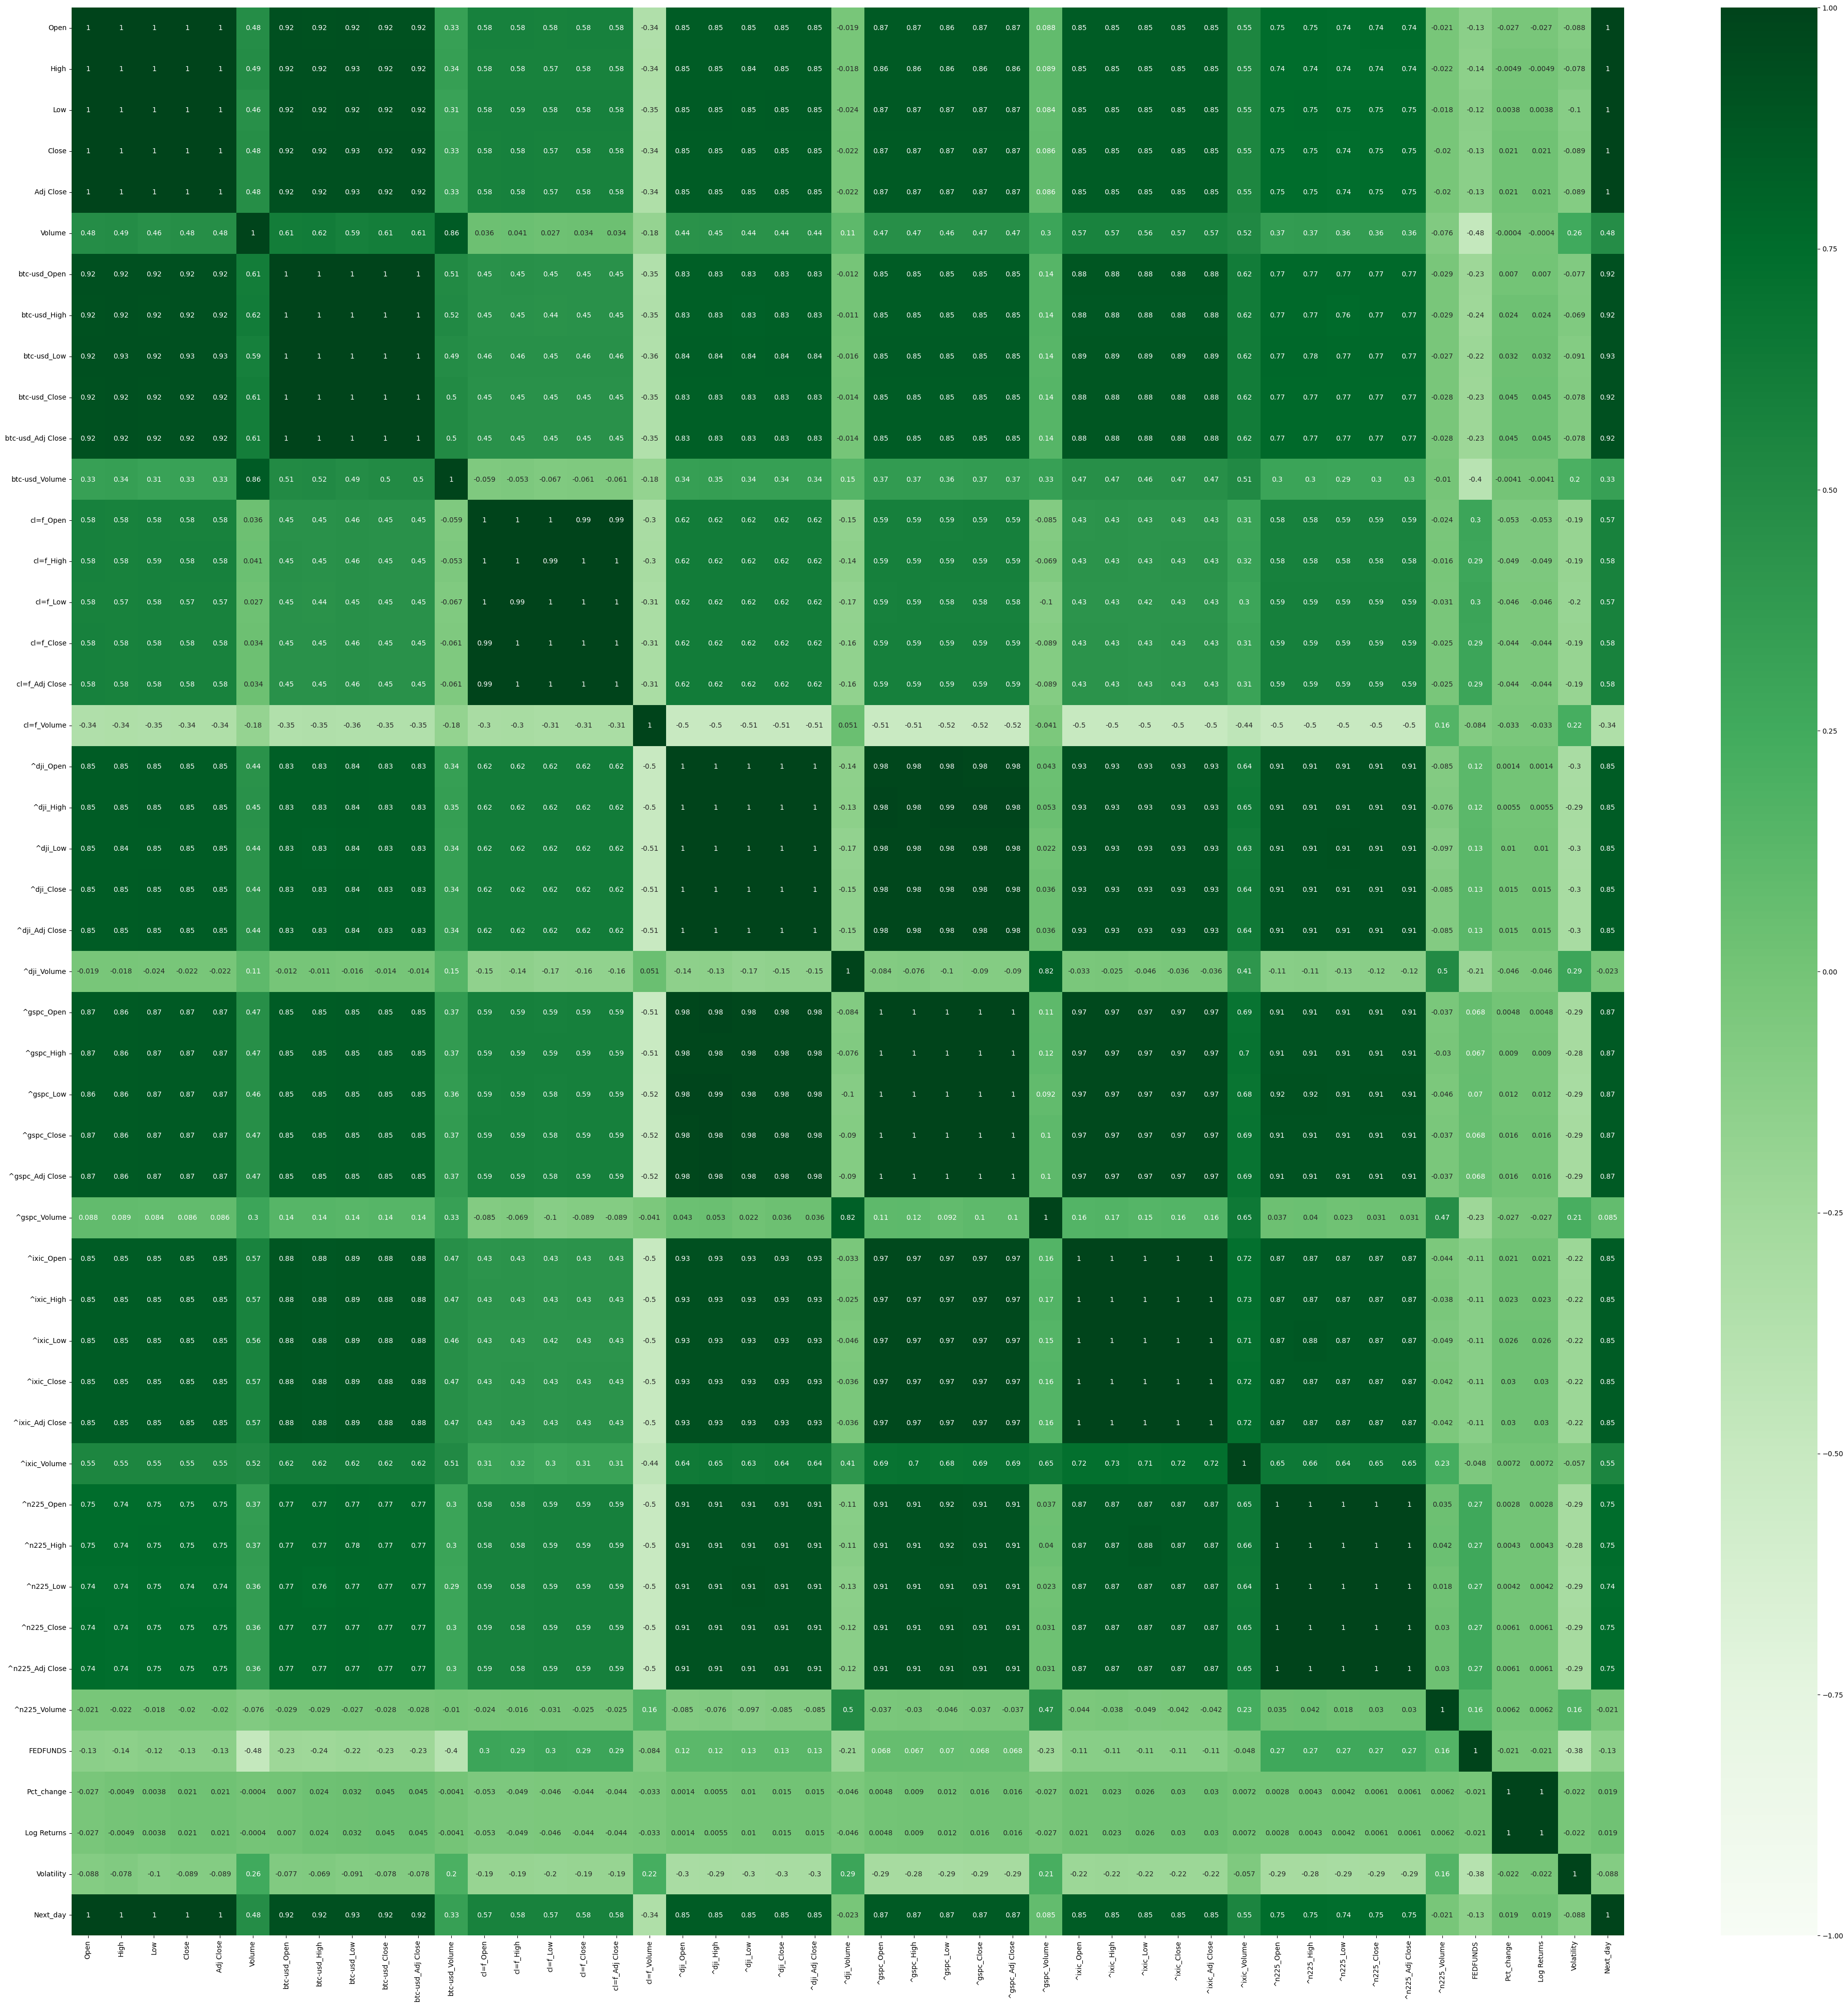

In [8]:
plt.rcParams["figure.figsize"] = (50,50)
sns.heatmap(df.corr(),
           annot = True, #Vaue on the heatmap
           cmap = 'Greens', #Colour
           vmin = -1, vmax=1 , #Boundary of Colour chart -1 ~ +1
          )

In [9]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'btc-usd_Open',
       'btc-usd_High', 'btc-usd_Low', 'btc-usd_Close', 'btc-usd_Adj Close',
       'btc-usd_Volume', 'cl=f_Open', 'cl=f_High', 'cl=f_Low', 'cl=f_Close',
       'cl=f_Adj Close', 'cl=f_Volume', '^dji_Open', '^dji_High', '^dji_Low',
       '^dji_Close', '^dji_Adj Close', '^dji_Volume', '^gspc_Open',
       '^gspc_High', '^gspc_Low', '^gspc_Close', '^gspc_Adj Close',
       '^gspc_Volume', '^ixic_Open', '^ixic_High', '^ixic_Low', '^ixic_Close',
       '^ixic_Adj Close', '^ixic_Volume', '^n225_Open', '^n225_High',
       '^n225_Low', '^n225_Close', '^n225_Adj Close', '^n225_Volume',
       'FEDFUNDS','Pct_change', 'Log Returns', 'Volatility',  'Next_day']

scaled_df = scaler.fit_transform(df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

print(scaled_df)

          Open      High       Low     Close  Adj Close    Volume  \
0     0.082315  0.090914  0.073835  0.072595   0.072595  0.020736   
1     0.073413  0.079094  0.068694  0.076739   0.076739  0.011484   
2     0.076374  0.080574  0.074534  0.080848   0.080848  0.003642   
3     0.080954  0.081329  0.080649  0.080194   0.080194  0.000000   
4     0.080288  0.082697  0.079613  0.080703   0.080703  0.000561   
...        ...       ...       ...       ...        ...       ...   
2158  0.363858  0.357608  0.359986  0.358675   0.358675  0.078403   
2159  0.358840  0.356873  0.364731  0.357950   0.357950  0.039292   
2160  0.358095  0.358930  0.363139  0.361954   0.361954  0.040878   
2161  0.362121  0.362833  0.366010  0.365030   0.365030  0.078890   
2162  0.365198  0.360903  0.367133  0.366377   0.366377  0.066248   

      btc-usd_Open  btc-usd_High  btc-usd_Low  btc-usd_Close  ...  ^n225_High  \
0         0.106372      0.125805     0.101435       0.103402  ...    0.334546   
1        

In [10]:
features  = df.columns[:-1]

In [11]:
df.shape

(2163, 47)

In [12]:
# Split original data into input sequences and target values
lookback = 10 # Using past 10 days' daily data of below columns' data to predict the 'Next_day' price
data_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'btc-usd_Open',
       'btc-usd_High', 'btc-usd_Low', 'btc-usd_Close', 'btc-usd_Adj Close',
       'btc-usd_Volume', 'cl=f_Open', 'cl=f_High', 'cl=f_Low', 'cl=f_Close',
       'cl=f_Adj Close', 'cl=f_Volume', '^dji_Open', '^dji_High', '^dji_Low',
       '^dji_Close', '^dji_Adj Close', '^dji_Volume', '^gspc_Open',
       '^gspc_High', '^gspc_Low', '^gspc_Close', '^gspc_Adj Close',
       '^gspc_Volume', '^ixic_Open', '^ixic_High', '^ixic_Low', '^ixic_Close',
       '^ixic_Adj Close', '^ixic_Volume', '^n225_Open', '^n225_High',
       '^n225_Low', '^n225_Close', '^n225_Adj Close', '^n225_Volume',
        'FEDFUNDS','Pct_change', 'Log Returns', 'Volatility']
target_columns = ['Next_day']

df_reset = df.reset_index(drop=True)

X = []
y = []

for i in range(len(df_reset) - lookback):
    X.append(df_reset.loc[i:i+lookback-1, data_columns].values)  # to select only the columns specified in data_columns
    y.append(df_reset.loc[i+lookback, target_columns].values[0])  # select the target value

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)


In [13]:
# Scale the input sequences (X)
scaler = MinMaxScaler()
#X = scaler.fit_transform(X_pca.reshape(X.shape[0], -1))
X = scaler.fit_transform(X.reshape(X.shape[0], -1))

# Scale the target variable (y)
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1))

In [14]:
###############################################
tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=64)
for train_index, test_index in tscv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
###############################################

In [15]:
X_train = X_train.reshape((X_train.shape[0], lookback, -1))
X_test = X_test.reshape((X_test.shape[0], lookback, -1))

In [16]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2089, 10, 46) (64, 10, 46)
(2089, 1) (64, 1)


In [17]:
def build_single_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(256, return_sequences=False, input_shape= input_shape))
    model.add(Dense(50))
    model.add(Dense(70))
    model.add(Dense(1))
    #model.compile(optimizer='Adam', loss='mean_squared_error')
    model.compile(optimizer='Adam', loss='mean_squared_error')

    return model

In [18]:
input_shape = (X_train.shape[1], X_train.shape[2])
single_lstm_model = build_single_lstm_model(input_shape)
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100, mode='min')
# Train the model

single_history = single_lstm_model.fit(X_train, y_train, epochs=100, batch_size=64,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

Train on 2089 samples, validate on 64 samples
Epoch 1/100
2089/2089 [==============================] - 2s 990us/sample - loss: 0.0504 - val_loss: 0.0029
Epoch 2/100
 960/2089 [============>.................] - ETA: 0s - loss: 0.0035

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


2089/2089 [==============================] - 0s 124us/sample - loss: 0.0025 - val_loss: 3.6740e-04
Epoch 3/100
2089/2089 [==============================] - 0s 180us/sample - loss: 0.0012 - val_loss: 2.0176e-04
Epoch 4/100
2089/2089 [==============================] - 0s 190us/sample - loss: 0.0011 - val_loss: 3.9085e-04
Epoch 5/100
2089/2089 [==============================] - 0s 207us/sample - loss: 9.9309e-04 - val_loss: 1.5350e-04
Epoch 6/100
2089/2089 [==============================] - 0s 171us/sample - loss: 0.0010 - val_loss: 4.1512e-04
Epoch 7/100
2089/2089 [==============================] - 0s 179us/sample - loss: 8.9386e-04 - val_loss: 4.0445e-04
Epoch 8/100
2089/2089 [==============================] - 0s 201us/sample - loss: 8.5593e-04 - val_loss: 2.8063e-04
Epoch 9/100
2089/2089 [==============================] - 0s 182us/sample - loss: 8.4202e-04 - val_loss: 2.2522e-04
Epoch 10/100
2089/2089 [==============================] - 0s 199us/sample - loss: 8.2585e-04 - val_loss: 1.9

In [19]:
single_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               310272    
                                                                 
 dense (Dense)               (None, 50)                12850     
                                                                 
 dense_1 (Dense)             (None, 70)                3570      
                                                                 
 dense_2 (Dense)             (None, 1)                 71        
                                                                 
Total params: 326763 (1.25 MB)
Trainable params: 326763 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


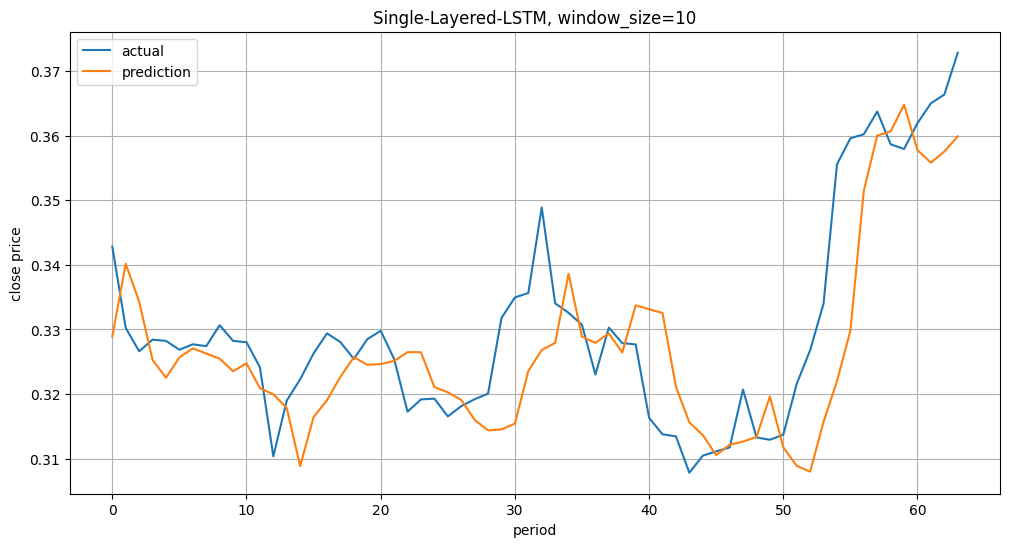

In [20]:
single_pred = single_lstm_model.predict(X_test)
plt.figure(figsize=(12, 6))
plt.title('Single-Layered-LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(single_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [21]:
y_single_pred_original = y_scaler.inverse_transform(single_pred)
y_single_test_original = y_scaler.inverse_transform(y_test)

In [22]:
df_reset = df.reset_index()

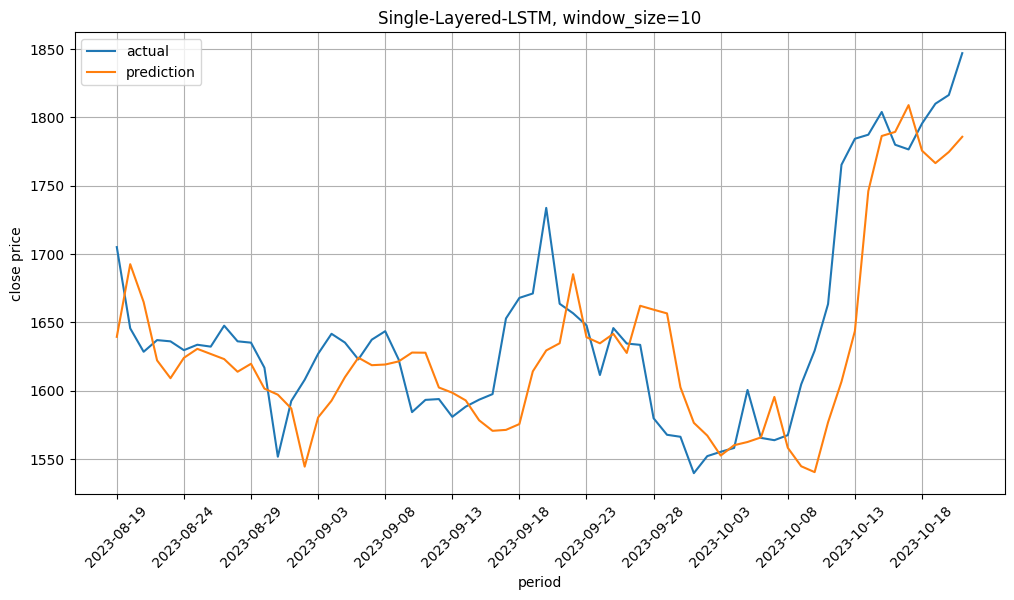

In [23]:
## Real values of prediction
date_values_bi = df_reset['Date'].iloc[test_index].values
plt.figure(figsize=(12, 6))
plt.title('Single-Layered-LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(date_values_bi,y_single_test_original, label='actual')
plt.plot(date_values_bi,y_single_pred_original, label='prediction')
plt.grid()
plt.legend(loc='best')
plt.xticks(np.arange(0, len(date_values_bi), step=5), date_values_bi[::5], rotation=45)

plt.show()

In [24]:
# Calculate error metrics
real_rmse_single = np.sqrt(mean_squared_error(y_single_test_original, y_single_pred_original))
real_mae_single = mean_absolute_error(y_single_test_original, y_single_pred_original)
real_mape_single = mean_absolute_percentage_error(y_single_test_original, y_single_pred_original)

# Print each value
print("RMSE of Single-Layered-LSTM :", real_rmse_single)
print("MAE of Single-Layered-LSTM :", real_mae_single)
print("MAPE of Single-Layered-LSTM :", real_mape_single)


RMSE of Single-Layered-LSTM : 49.09879340649105
MAE of Single-Layered-LSTM : 36.272212982177734
MAPE of Single-Layered-LSTM : 0.02179666796635768


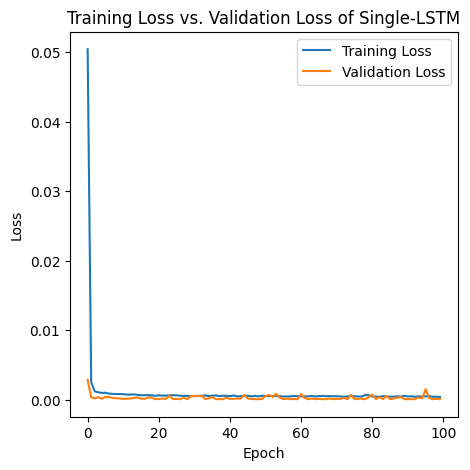

In [25]:
# Plot the training loss and validation loss over the epochs
plt.figure(figsize=(5, 5))
plt.plot(single_history.history['loss'])
plt.plot(single_history.history['val_loss'])
plt.title('Training Loss vs. Validation Loss of Single-LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [26]:
# Use the training data for deep explainer
explainer_stock_single = shap.DeepExplainer(single_lstm_model, X_train)
shap_values_stock_single = explainer_stock_single.shap_values(X_test)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [27]:
shap_values_stock_single[0][0].shape

(10, 46)

In [28]:
shap_values_single_2D = shap_values_stock_single[0].reshape(-1,46)
X_test_single_2D = X_test.reshape(-1,46)

shap_values_single_2D.shape, X_test_single_2D.shape

((640, 46), (640, 46))

In [29]:
X_test_single_2D

array([[0.33360859, 0.33453274, 0.33898059, ..., 0.70766634, 0.70766634,
        0.06729701],
       [0.33545874, 0.33434561, 0.34088464, ..., 0.71282221, 0.71282221,
        0.06948081],
       [0.33872476, 0.33283801, 0.33852409, ..., 0.6877912 , 0.6877912 ,
        0.06772847],
       ...,
       [0.35884031, 0.35687338, 0.36473149, ..., 0.6986937 , 0.6986937 ,
        0.08915609],
       [0.35809541, 0.35892968, 0.36313854, ..., 0.7146391 , 0.7146391 ,
        0.07470831],
       [0.36212122, 0.36283302, 0.36601037, ..., 0.711417  , 0.711417  ,
        0.07253318]])

In [30]:
features  = df.columns[:-1]
#features = df.columns
XX = df[features]

In [31]:
mapping_dict = {f: column_name for f, column_name in zip(features, XX.columns)}
actual_column_names = [mapping_dict[feature_name] for feature_name in features]

In [32]:
x_test_single_2d = pd.DataFrame(data=X_test_single_2D, columns = actual_column_names)

In [33]:
actual_column_names

['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'btc-usd_Open',
 'btc-usd_High',
 'btc-usd_Low',
 'btc-usd_Close',
 'btc-usd_Adj Close',
 'btc-usd_Volume',
 'cl=f_Open',
 'cl=f_High',
 'cl=f_Low',
 'cl=f_Close',
 'cl=f_Adj Close',
 'cl=f_Volume',
 '^dji_Open',
 '^dji_High',
 '^dji_Low',
 '^dji_Close',
 '^dji_Adj Close',
 '^dji_Volume',
 '^gspc_Open',
 '^gspc_High',
 '^gspc_Low',
 '^gspc_Close',
 '^gspc_Adj Close',
 '^gspc_Volume',
 '^ixic_Open',
 '^ixic_High',
 '^ixic_Low',
 '^ixic_Close',
 '^ixic_Adj Close',
 '^ixic_Volume',
 '^n225_Open',
 '^n225_High',
 '^n225_Low',
 '^n225_Close',
 '^n225_Adj Close',
 '^n225_Volume',
 'FEDFUNDS',
 'Pct_change',
 'Log Returns',
 'Volatility']

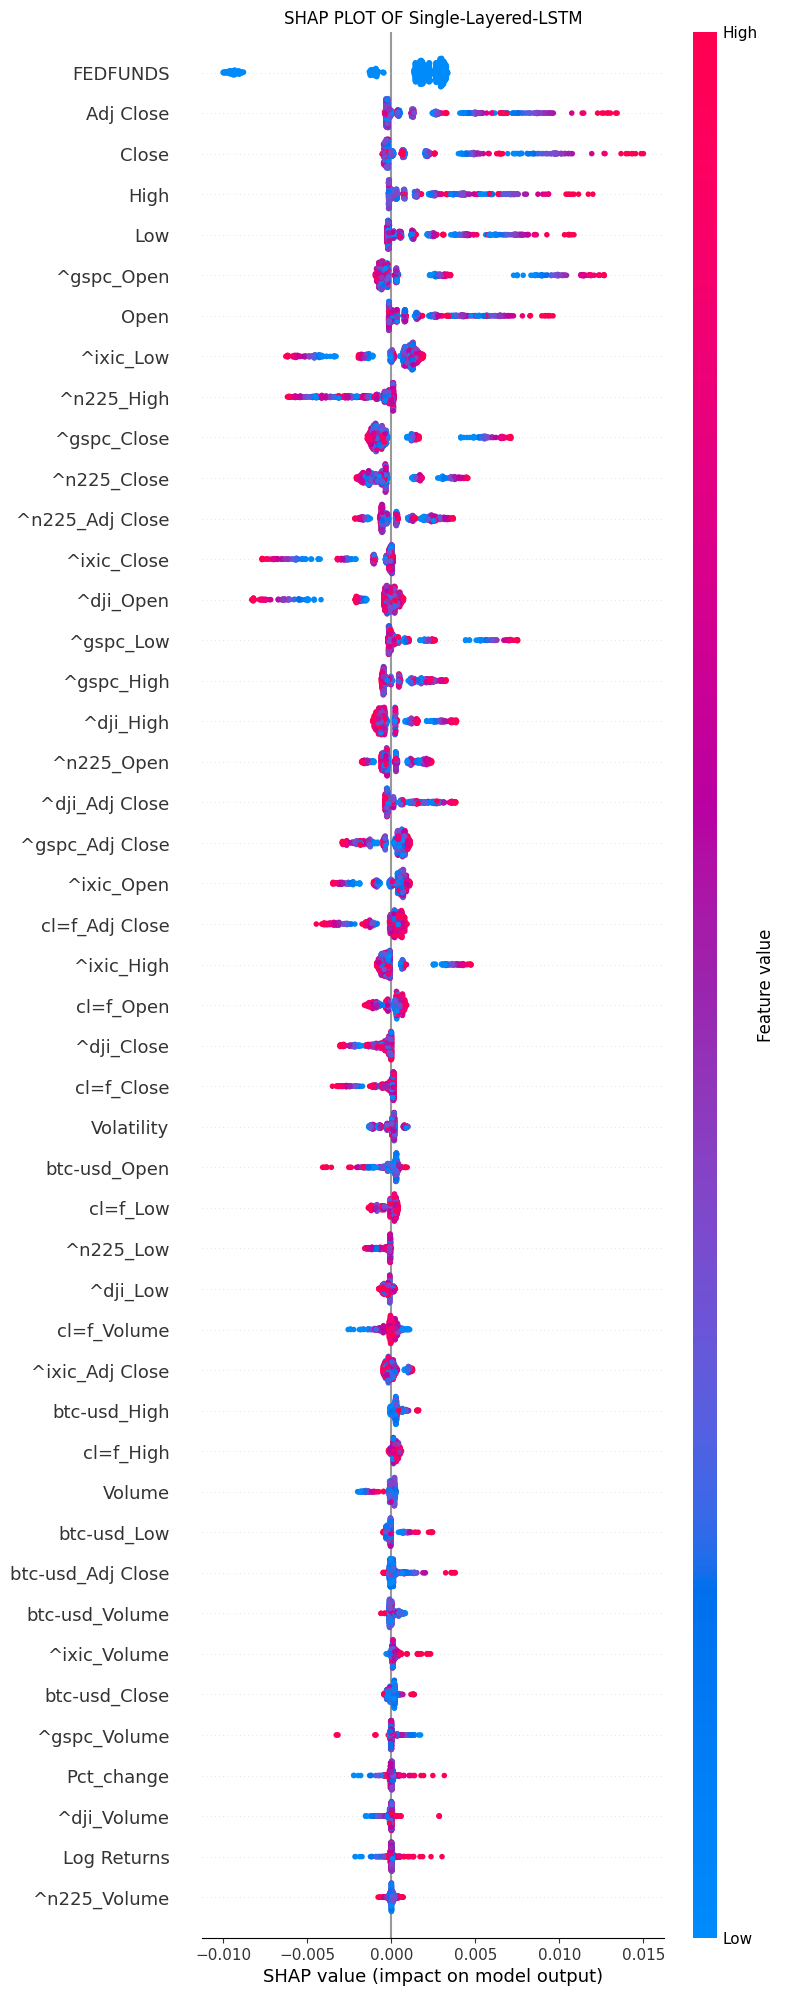

In [34]:
max_display_features = 49
shap.summary_plot(shap_values_single_2D, x_test_single_2d, max_display=max_display_features, show = False)
plt.title("SHAP PLOT OF Single-Layered-LSTM", loc='center')
plt.show()

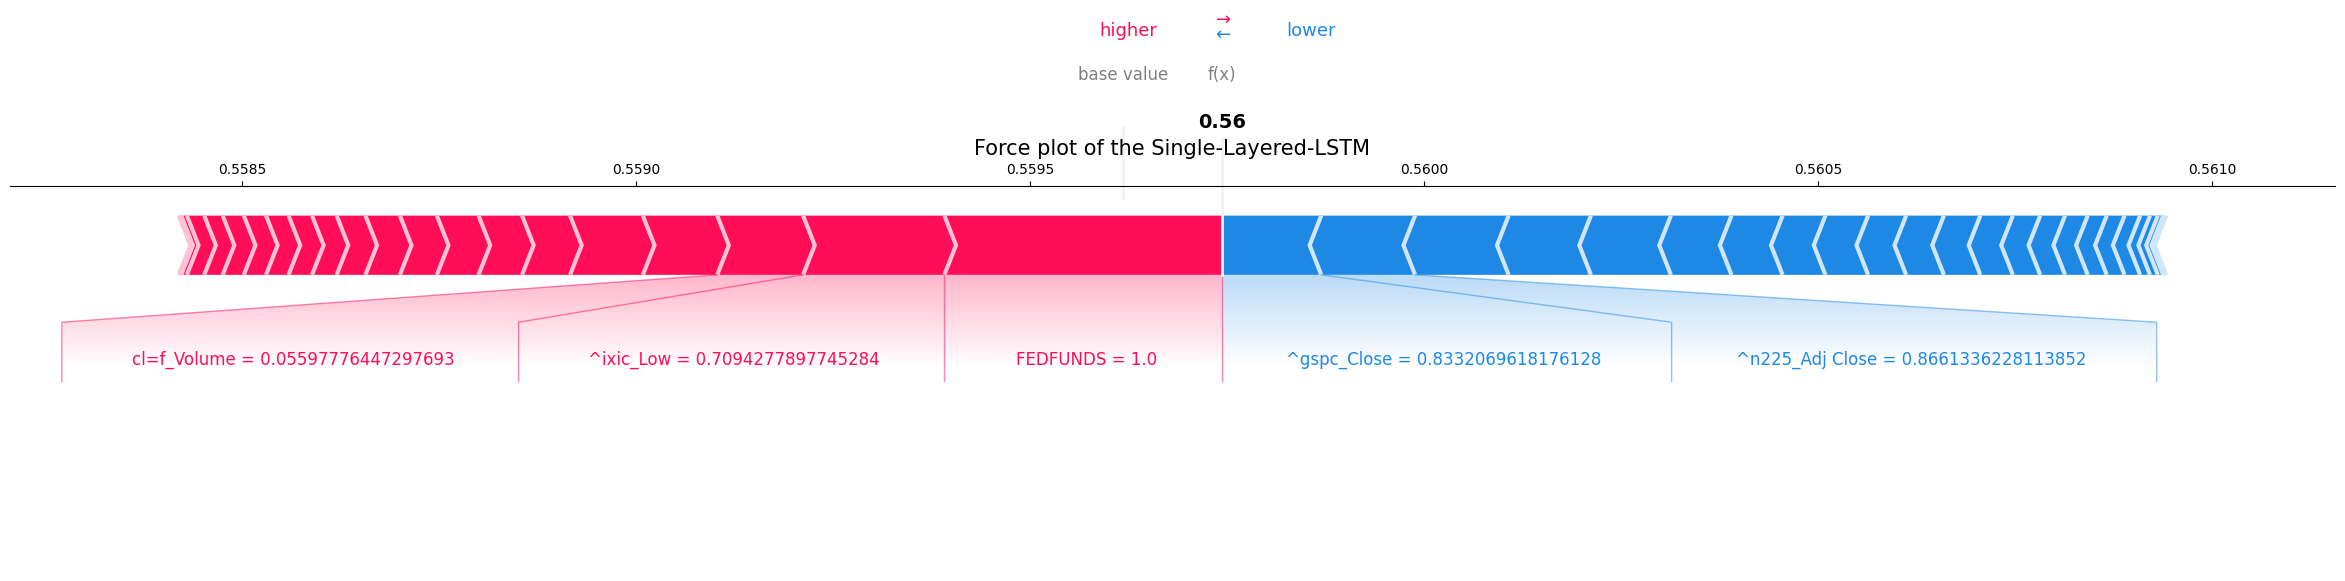

In [35]:
#Obtain Force Plot
expected_value_single = explainer_stock_single.expected_value[0]

instance_index = 0

shap.force_plot(expected_value_single, shap_values_single_2D[instance_index], x_test_single_2d.iloc[instance_index],
                link='logit', matplotlib=True, show = False,figsize=(30,5))

plt.title("Force plot of the Single-Layered-LSTM", fontsize=15)
plt.show()

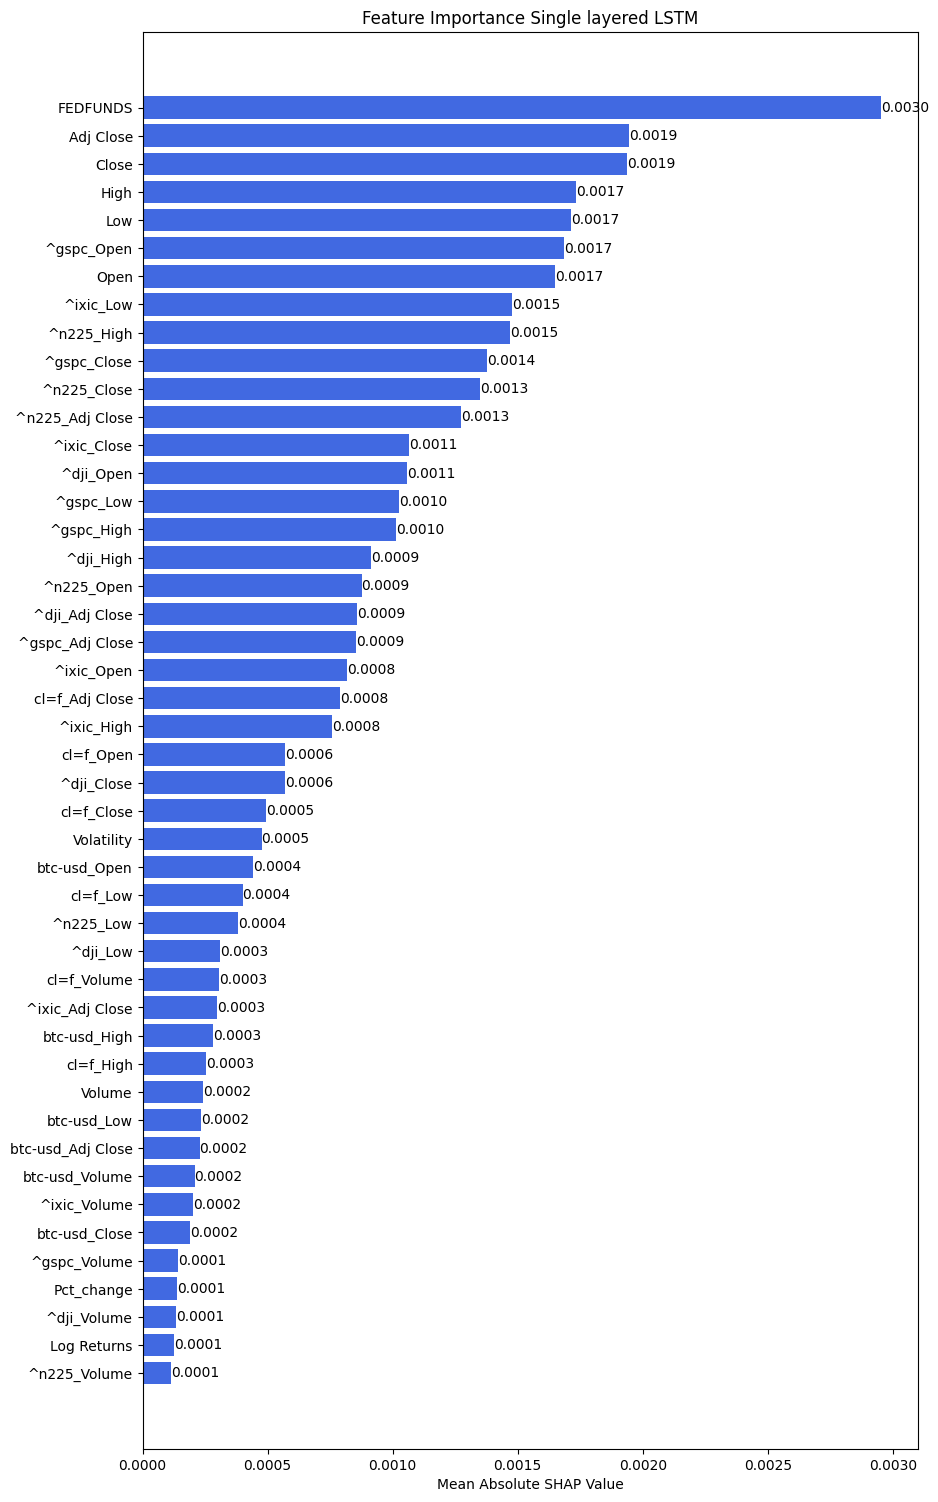

In [36]:
# Compute the mean absolute SHAP values for each feature
mean_shap_values_sin = np.abs(shap_values_single_2D).mean(axis=0)

# Sorting the features based on their mean absolute SHAP values
sorted_indices_sin = np.argsort(mean_shap_values_sin)[::-1]
sorted_features_sin = x_test_single_2d.columns[sorted_indices_sin]
sorted_shap_values_sin = mean_shap_values_sin[sorted_indices_sin]

# Create the bar plot
plt.figure(figsize=(10, len(sorted_features_sin) * 0.4))
plt.barh(sorted_features_sin, sorted_shap_values_sin, color='royalblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance Single layered LSTM')

# Annotate each bar with its exact value
for index, value in enumerate(sorted_shap_values_sin):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()